In [1]:
import numpy as np
import matplotlib.pylab as plt
import random
from scipy.special import comb

import os
import sys
sys.path.append('../src/')
sys.path.append('../scripts/')

import numpy as np
import networkx as nx
import random
from itertools import combinations

from higher_order_structures import HigherOrderStructure
from scipy.stats import zipf # for power-law Zeta distribution
from scipy.stats import powerlaw # more direct power-law draw
from scipy.optimize import curve_fit # for plotting fits

# Scale Free SC - Version 1

In [2]:
def generate_sf_sc_components_final(N_nodes, m_min_kgi, gamma_kgi,
                                   max_retries_for_stub_set=10, # N // 100, for N = 1000
                                   max_initial_stub_gen_attempts=100):
    r"""
    Generates a Simplicial Complex (up to 2-simplices) with scale-free
    generalized degrees for 2-simplices k_gi = target number of triangles a node is part of.

    Given:
        * m_min_kgi: minimum number of target triangles per node
        * gamma_kgi: exponent of P(k_gi) ~ k_gi^(-gamma_kgi)
        * max_retries_for_stub_set: max retries if current 3 stubs form an illegal triangle
        * max_initial_stub_gen_attempts: max attempts to generate valid total stub sum

    Adapted from:
        * O.T. Courtney and G. Bianconi
        * "Generalized network structures: the configuration model and the canonical ensemble of
        * simplicial complexes"
        * Phys. Rev. E 93, 062311 (2016)
        * http://dx.doi.org/10.1103/PhysRevE.93.062311
        * https://github.com/ginestrab/Ensembles-of-Simplicial-Complexes/blob/8c32d11a281f31813c8e0693cd010b07e2c823b3/SC_d2.c    
    """
    kgi_stubs_generated = np.zeros(N_nodes, dtype=int)
    for _ in range(max_initial_stub_gen_attempts):
        for i in range(N_nodes):
            u = random.random()
            while u == 0.0: u = random.random()
            drawn_kgi = int(m_min_kgi * (u**(-1.0 / (gamma_kgi - 1.0))))
            kgi_stubs_generated[i] = max(m_min_kgi, drawn_kgi)
            max_poss_tri_node = (N_nodes - 1) * (N_nodes - 2) / 2.0
            kgi_stubs_generated[i] = min(kgi_stubs_generated[i], int(max_poss_tri_node))
            if kgi_stubs_generated[i] < 0: kgi_stubs_generated[i] = 0

        total_stubs = np.sum(kgi_stubs_generated)
        if total_stubs % 3 == 0 and total_stubs >=3 : break
    else:
        remainder = total_stubs % 3
        if remainder != 0:
            eligible_nodes = np.where(kgi_stubs_generated > m_min_kgi)[0]
            if len(eligible_nodes) < remainder: eligible_nodes = np.where(kgi_stubs_generated > 0)[0]
            for _i_dec in range(remainder):
                if not eligible_nodes.size: break
                node_to_dec = random.choice(eligible_nodes)
                if kgi_stubs_generated[node_to_dec] > 0: kgi_stubs_generated[node_to_dec] -= 1
            total_stubs = np.sum(kgi_stubs_generated)
        if total_stubs < 3 or total_stubs % 3 != 0:
            print(f"Failed, returning empty SC components. Final stubs: {total_stubs}")
            return 0, [], []

    stub_list = []
    for node_idx, num_s in enumerate(kgi_stubs_generated):
        stub_list.extend([node_idx] * num_s)
    random.shuffle(stub_list)

    triangles_set = set()
    edges_set = set()
    
    current_stub_idx = 0
    while current_stub_idx + 2 < len(stub_list):
        retries_for_current_set = 0
        while retries_for_current_set < max_retries_for_stub_set:
            if current_stub_idx + 2 >= len(stub_list): break # ran out of stubs

            node1 = stub_list[current_stub_idx]
            node2 = stub_list[current_stub_idx + 1]
            node3 = stub_list[current_stub_idx + 2]

            is_legal = False
            if len({node1, node2, node3}) == 3: # nodes should be distinct
                proposed_triangle = tuple(sorted((node1, node2, node3)))
                if proposed_triangle not in triangles_set:
                    is_legal = True
            
            if is_legal:
                triangles_set.add(proposed_triangle)
                edges_set.add(tuple(sorted((node1, node2))))
                edges_set.add(tuple(sorted((node1, node3))))
                edges_set.add(tuple(sorted((node2, node3))))
                current_stub_idx += 3 # used all 3 stubs
                break # break from retry for this set
            else:
                retries_for_current_set += 1
                if retries_for_current_set < max_retries_for_stub_set:
                    # NOTE: simple backtrack: 
                    # reshuffle remaining stubs and retry current position
                    if len(stub_list[current_stub_idx:]) >=3:
                         # reshuffle the tail from current_stub_idx to the end
                         # next attempt at current_stub_idx should pick different stubs
                        temp_tail = stub_list[current_stub_idx:]
                        random.shuffle(temp_tail)
                        stub_list[current_stub_idx:] = temp_tail
                    else: 
                        # not enough stubs to retry
                        current_stub_idx +=3 # give up on these 3
                        # break from retry
                        break 
                else: 
                    # max retries for this specific set of 3 stubs
                    # print(f"max retries for stubs at index {current_stub_idx}, moving on")
                    current_stub_idx += 3 # give up on these 3
                    break # break from retry
        else: 
            # retry loop finisheed due to max_retries and didn't break before
            if current_stub_idx + 2 >= len(stub_list): 
                break
        
    # returning kgi_stubs_generated for plots 
    return N_nodes, list(edges_set), list(triangles_set), kgi_stubs_generated

In [3]:
# seems to produce reasonable scale-free simplicial complex
# TODO: tune `m_sc`, `gamma_sc`, and perhaps `max_retries_for_stub_set`
# to get distributions that look good and have a sufficient number of simplices

# setup 
# m_sc = m_min_kgi: minimum number of target triangles per node 
# gamma_sc = gamma_kgi for HO degrees
N = 1000
m_sc = 2
gamma_sc = 2.5
max_retries_for_stub_set = N // 100

N, sc_edges, sc_triangles, kgi_generated = generate_sf_sc_components_final(N, m_sc, gamma_sc, max_retries_for_stub_set)

print(f"\nSF-SC with {N} nodes.")
print(f"number of 1-simplices (edges): {len(sc_edges)}")
print(f"number of 2-simplices (triangles): {len(sc_triangles)}")


SF-SC with 1000 nodes.
number of 1-simplices (edges): 4384
number of 2-simplices (triangles): 1516


In [4]:
g_sc = HigherOrderStructure(N)
all_simplices_sc = sc_edges + sc_triangles
g_sc.set_edges(all_simplices_sc)
g_sc.name = f"ScaleFreeSC"
g_sc.print()

	ScaleFreeSC on 1000 nodes with 5900 edges.



In [5]:
pw_degrees_sc = np.zeros(N, dtype=int)
ho_degrees_sc = np.zeros(N, dtype=int)

for i in range(N):
    pw_degrees_sc[i] = len(g_sc.neighbors(i, 1))
    ho_degrees_sc[i] = len(g_sc.neighbors(i, 2))

realized_avg_pw = np.mean(pw_degrees_sc)
realized_max_pw = np.max(pw_degrees_sc)

realized_avg_pw, realized_max_pw

(np.float64(8.768), np.int64(186))

In [6]:
np.var(pw_degrees_sc), np.var(ho_degrees_sc)

(np.float64(150.69417599999997), np.float64(49.69369600000001))

In [6]:
realized_avg_ho = np.mean(ho_degrees_sc)
realized_max_ho = np.max(ho_degrees_sc)

realized_avg_ho, realized_max_ho



(np.float64(5.334), np.int64(135))

In [7]:
def test_generate_sf_sc(pw_degrees_sc, ho_degrees_sc, kgi_generated,
                        N, gamma_sc, m_sc, figure_fname):

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    title = f"Degree Distributions: ScaleFreeSC with N = {N}, target gamma_ho = {gamma_sc}, target m_ho = {m_sc}"
    fig.suptitle(title, fontsize=16)

    # -------------
    # PW degrees
    ax = axes[0]

    realized_avg_pw = np.mean(pw_degrees_sc)
    realized_max_pw = np.max(pw_degrees_sc)
    min_val_pw = np.min(pw_degrees_sc)

    bins_pw = np.logspace(np.log10(min_val_pw), np.log10(realized_max_pw + 1), 25)
    counts_pw, _ = np.histogram(pw_degrees_sc, bins=bins_pw, density=True)
    bin_centers_pw = (bins_pw[:-1] + bins_pw[1:]) / 2
    valid_pw = counts_pw > 0

    ax.loglog(bin_centers_pw[valid_pw], counts_pw[valid_pw], 'x', color='red',
                markersize=7, alpha=0.9, label='Realized PW Degrees')

    # power-law fit for realized PW degrees

    def power_law_func_log(log_k, log_C, gamma_fit_param): return log_C - gamma_fit_param * log_k

    # some reasonable initial guess for gamma_pw_fit: gamma_sc or 2.5
    popt_pw, _ = curve_fit(power_law_func_log, 
                        np.log10(bin_centers_pw[valid_pw]), 
                        np.log10(counts_pw[valid_pw]), 
                        p0=[0, gamma_sc], 
                        maxfev=3000)

    gamma_pw_fit_val = popt_pw[1]
    k_fit_range = np.logspace(np.log10(bin_centers_pw[valid_pw][0]), np.log10(bin_centers_pw[valid_pw][-1]), 50)

    # theoretical fit as solid black line
    ax.plot(k_fit_range, (10**popt_pw[0]) * k_fit_range**(-gamma_pw_fit_val), 'k-', alpha=0.8,
                label=f'Fit: P(k_pw) ~ k_pw^{{-{gamma_pw_fit_val:.2f}}}')


    ax.set_title(f'PW Degrees, Realized Avg = {realized_avg_pw:.2f}, Realized Max = {realized_max_pw}')
    ax.set_xlabel('Pairwise Degree k_pw')
    ax.set_ylabel('P(k_pw)')
    ax.legend()
    ax.grid(True, which="both", ls=":", alpha=0.7)

    # -------------
    # HO degrees
    ax = axes[1]
    realized_avg_ho = 0
    realized_max_ho = 0

    realized_avg_ho = np.mean(ho_degrees_sc)
    realized_max_ho = np.max(ho_degrees_sc)
    min_val_ho = np.min(ho_degrees_sc)

    bins_ho_actual = np.logspace(np.log10(min_val_ho), np.log10(realized_max_ho + 1), 25)
    counts_ho_actual, _ = np.histogram(ho_degrees_sc, bins=bins_ho_actual, density=True)
    bin_centers_ho_actual = (bins_ho_actual[:-1] + bins_ho_actual[1:]) / 2
    valid_ho_actual = counts_ho_actual > 0

    # realized HO degrees as red crosses
    ax.loglog(bin_centers_ho_actual[valid_ho_actual], counts_ho_actual[valid_ho_actual], 'x', color='red',
                markersize=7, alpha=0.9, label='Realized HO Degrees (k_ho)')

    # plot the target kgi distribution, sequence of HO degrees

    min_val_kgi = np.min(kgi_generated[kgi_generated > 0]) if np.any(kgi_generated > 0) else 1
    max_val_kgi = np.max(kgi_generated)

    bins_kgi = np.logspace(np.log10(min_val_kgi), np.log10(max_val_kgi + 1), 25)
    counts_kgi, _ = np.histogram(kgi_generated, bins=bins_kgi, density=True)
    bin_centers_kgi = (bins_kgi[:-1] + bins_kgi[1:]) / 2
    valid_kgi = counts_kgi > 0

    # target generalized degrees as blue dots
    ax.loglog(bin_centers_kgi[valid_kgi], counts_kgi[valid_kgi], 'o', color='blue', markersize=5,
                alpha=0.7, label='Target Gen. Degree (k_gi) Dist.')

    # theoretical line P(k) ~ k^-gamma_sc for k_gi
    k_plot = np.logspace(np.log10(max(m_sc,1 if min_val_kgi==0 else min_val_kgi)), 
                        np.log10(max_val_kgi if max_val_kgi > m_sc else m_sc +1.01), 50)

    idx_min_kgi_bin = np.where(bin_centers_kgi[valid_kgi] >= m_sc)[0]

    k_min_plot_for_norm = bin_centers_kgi[valid_kgi][idx_min_kgi_bin[0]]
    P_k_min_plot = counts_kgi[valid_kgi][idx_min_kgi_bin[0]]
    C_norm = P_k_min_plot * (k_min_plot_for_norm**(gamma_sc))

    # theoretical fit as solid black line
    ax.loglog(k_plot, C_norm * (k_plot**(-gamma_sc)),
                'k-', alpha=0.8, label=f'Target P(k_gi) ~ k_gi^{{-{gamma_sc:.2f}}}')

    ax.set_title(f'HO Degrees, Realized Avg = {realized_avg_ho:.2f}, Realized Max = {realized_max_ho}')
    ax.set_xlabel('Degree (k_ho or k_gi)')
    ax.set_ylabel('P(degree)')
    ax.legend()
    ax.grid(True, which="both", ls=":", alpha=0.7)

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    
    save_dir = "../figures/higher_order_structures/"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{figure_fname}.pdf")
    plt.savefig(save_path, format="pdf", bbox_inches="tight")
    print(f"Figure saved to: {save_path}")
    plt.show()

	ScaleFreeSC on 1000 nodes with 6871 edges.

Figure saved to: ../figures/higher_order_structures/degree_distributions_scale_free_sc_N1000_m2_gamma2.5.pdf


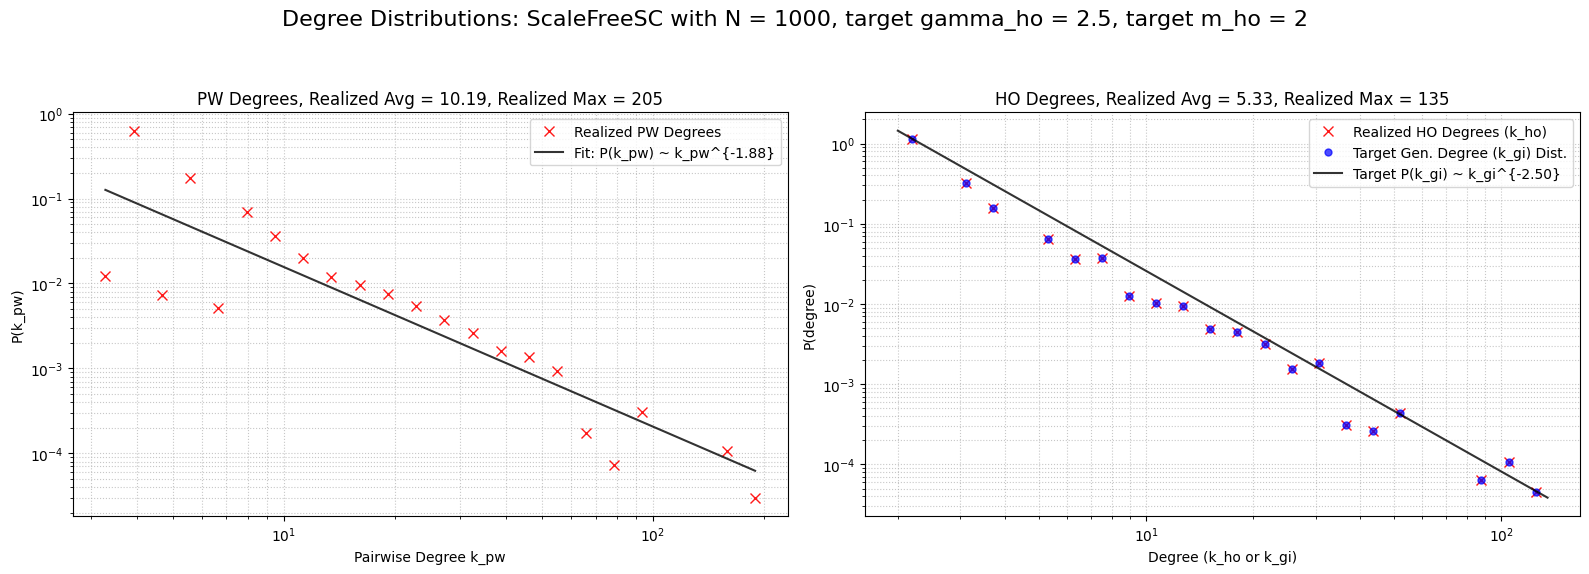

In [8]:
g_sc = HigherOrderStructure(N)
all_simplices_sc = sc_edges + sc_triangles
g_sc.set_edges(all_simplices_sc)
g_sc.name = f"ScaleFreeSC"
g_sc.print()

pw_degrees_sc = np.zeros(N, dtype=int)
ho_degrees_sc = np.zeros(N, dtype=int)

for i in range(N):
    pw_degrees_sc[i] = len(g_sc.neighbors(i, 1))
    ho_degrees_sc[i] = len(g_sc.neighbors(i, 2))
    
figure_fname = f"degree_distributions_scale_free_sc_N{N}_m{m_sc}_gamma{gamma_sc}"
test_generate_sf_sc(pw_degrees_sc, ho_degrees_sc, kgi_generated, N, gamma_sc, m_sc, figure_fname)

# Compare with `./test/SC_d2_mod.c` version

In [9]:
def load_c_output_edges(filename):
    edges = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                u, v = int(parts[0]), int(parts[1])
                edges.append(tuple(sorted((u, v)))) # Store as sorted tuple
    return list(set(edges)) # Return unique edges

def load_c_output_triangles(filename):
    triangles = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 3:
                u, v, w = int(parts[0]), int(parts[1]), int(parts[2])
                triangles.append(tuple(sorted((u, v, w)))) # Store as sorted tuple
    return list(set(triangles)) # Return unique triangles

In [10]:
# used the same values of parameters
# N = 1000
# m_sc = 2
# gamma_sc = 2.5

sc_edges_fname = "../tests/SC_d2_edges.txt"
sc_triangles_fname = "../tests/SC_d2_triangles.txt"

c_sc_edges = load_c_output_edges(sc_edges_fname)
c_sc_triangles = load_c_output_triangles(sc_triangles_fname)

print(f"number of edges {len(c_sc_edges)}")
print(f"number of triangles: {len(c_sc_triangles)}")

g_sc_c = HigherOrderStructure(N)
g_sc_c.set_edges(c_sc_edges + c_sc_triangles)
g_sc_c.name = f"ScaleFreeSC_mod_c"
g_sc_c.print()

number of edges 4840
number of triangles: 1811
	ScaleFreeSC_mod_c on 1000 nodes with 6651 edges.



Figure saved to: ../figures/higher_order_structures/degree_distributions_scale_free_sc_N1000_m2_gamma2.5_mod_c.pdf


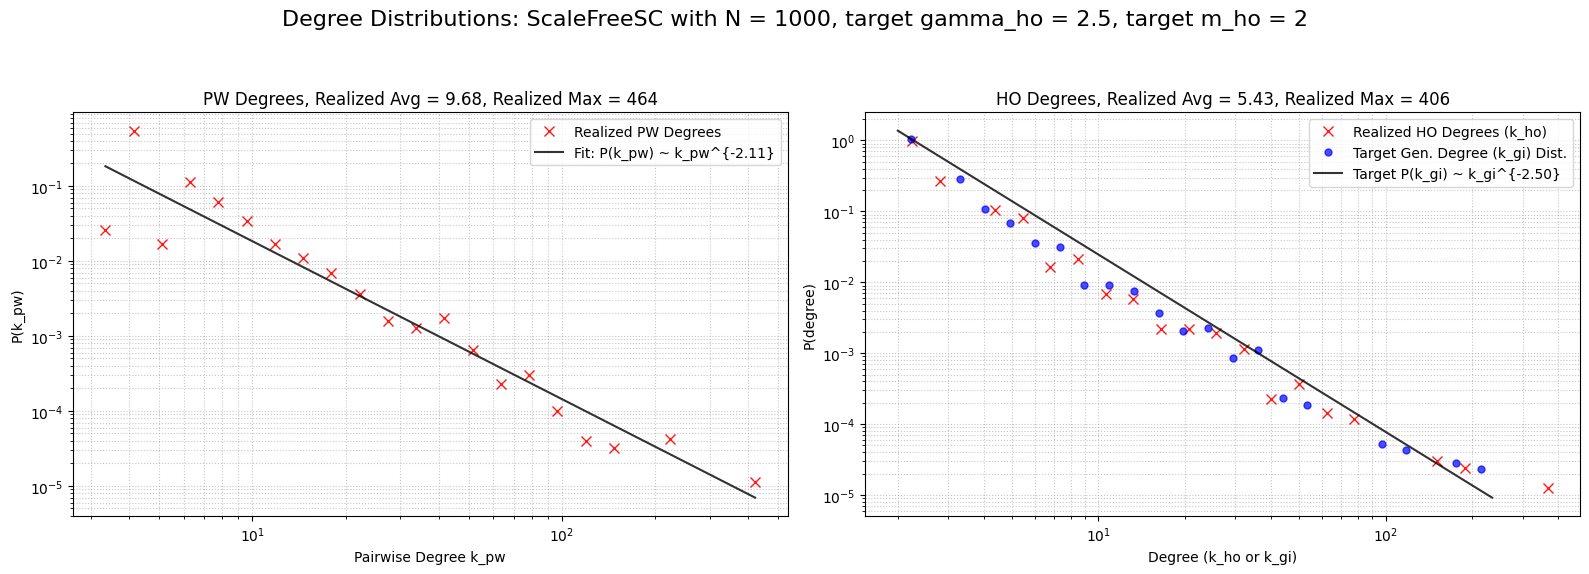

In [11]:
pw_degrees_from_c = np.zeros(N, dtype=int)
ho_degrees_from_c = np.zeros(N, dtype=int)
for i in range(N):
    pw_degrees_from_c[i] = len(g_sc_c.neighbors(i, 1))
    ho_degrees_from_c[i] = len(g_sc_c.neighbors(i, 2))

kgi_target_for_plot = np.zeros(N, dtype=int)
for i in range(N):
    u = random.random()
    while u == 0.0: 
        u = random.random()
    
    drawn_kgi = int(m_sc * (u**(-1.0 / (gamma_sc - 1.0))))
    kgi_target_for_plot[i] = max(m_sc, drawn_kgi)
    
    max_poss_tri_node = (N - 1) * (N - 2) / 2.0
    kgi_target_for_plot[i] = min(kgi_target_for_plot[i], int(max_poss_tri_node))

    if kgi_target_for_plot[i] < 0: 
        kgi_target_for_plot[i] = 0

figure_fname = f"degree_distributions_scale_free_sc_N{N}_m{m_sc}_gamma{gamma_sc}_mod_c"
test_generate_sf_sc(pw_degrees_from_c, ho_degrees_from_c, kgi_target_for_plot, N, gamma_sc, m_sc, figure_fname)        